<a href="https://colab.research.google.com/github/Nautyy9/VAE/blob/main/VAE_36hrs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential, Input , Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, Flatten, Dense, Layer, Reshape, Conv2DTranspose
import numpy as np
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [ ]:
(x_train, y_train ), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32")/255

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(mnist_digits)

In [ ]:
Batch_size = 128
Latent_dim = 2

In [ ]:
train_dataset = (
    dataset
    .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
    .batch(Batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
train_dataset

<_PrefetchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

#Data Modelling

## Encoder


In [ ]:
print(Batch_size, Latent_dim)

128 2


In [ ]:
class Encoding(Layer):
  def __call__(self, inputs):
    mean , log_var = inputs
    print(tf.shape(mean), tf.shape(mean)[0], tf.shape(mean)[1])
    return mean + tf.math.exp(0.5*log_var)*tf.random.normal(shape = (tf.shape(mean)[0], tf.shape(mean)[1]))

In [ ]:
encoder  =  Input(shape=(28,28,1))

x = Conv2D(32, 3, strides =2 , activation="relu", padding="same")(encoder)
x = Conv2D(64, 3, strides =2 , activation="relu", padding="same")(x)

x= Flatten()(x)
x= Dense(16, activation = "relu")(x)

mean = Dense(Latent_dim,)(x)
log_var = Dense(Latent_dim, )(x)

output = Encoding()([mean, log_var])

encoder_model = Model(encoder, [output, mean, log_var], name="encoder_model")
encoder_model.summary()

KerasTensor(type_spec=TensorSpec(shape=(2,), dtype=tf.int32, name=None), inferred_value=[None, 2], name='tf.compat.v1.shape_5/Shape:0', description="created by layer 'tf.compat.v1.shape_5'") KerasTensor(type_spec=TensorSpec(shape=(), dtype=tf.int32, name=None), inferred_value=[None], name='tf.__operators__.getitem_4/strided_slice:0', description="created by layer 'tf.__operators__.getitem_4'") KerasTensor(type_spec=TensorSpec(shape=(), dtype=tf.int32, name=None), inferred_value=[2], name='tf.__operators__.getitem_5/strided_slice:0', description="created by layer 'tf.__operators__.getitem_5'")
Model: "encoder_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                

## Decoder

In [ ]:
# now the decoder is opposite of encoder up there we're downsampling the image size but in here we are up-sampling image size hence we've used Conv2DTranspose
# which add padding's or say up-scale the size , here the structure goes like ----> initially we've size of (Batch_size, 2)
                  # then we use Dense layer of filters -> (7,7,64) -> now 7,7 would give us 14,14 which give 28,28 on up_sampling
                  # this we do to turn size from -----> (Batch_size , 2) ------> (Batch_size, 7,7,64)

# Below we see the no.of channels goes from 64 to 32 but above we're increasing because we want o/p channels to be 1 i.e, (28,28,1)

latent_input  = Input(shape =(Latent_dim,))

x = Dense(7*7*64, activation="relu")(latent_input)
x=Reshape((7,7,64))(x)

x= Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)
x= Conv2DTranspose(32, 3, activation="relu" , padding="same", strides=2)(x)

decoder_output = Conv2DTranspose(1, 3 , activation="sigmoid", padding="same")(x)
decoder_model = Model(latent_input, decoder_output, name="decoder_model")
decoder_model.summary()

Model: "decoder_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_7 (Dense)             (None, 3136)              9408      
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 14, 14, 64)       36928     
 ranspose)                                                       
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 28, 28, 1)      

## Compile

In [ ]:
optimizer = Adam(learning_rate = 1e-3)
epochs = 100

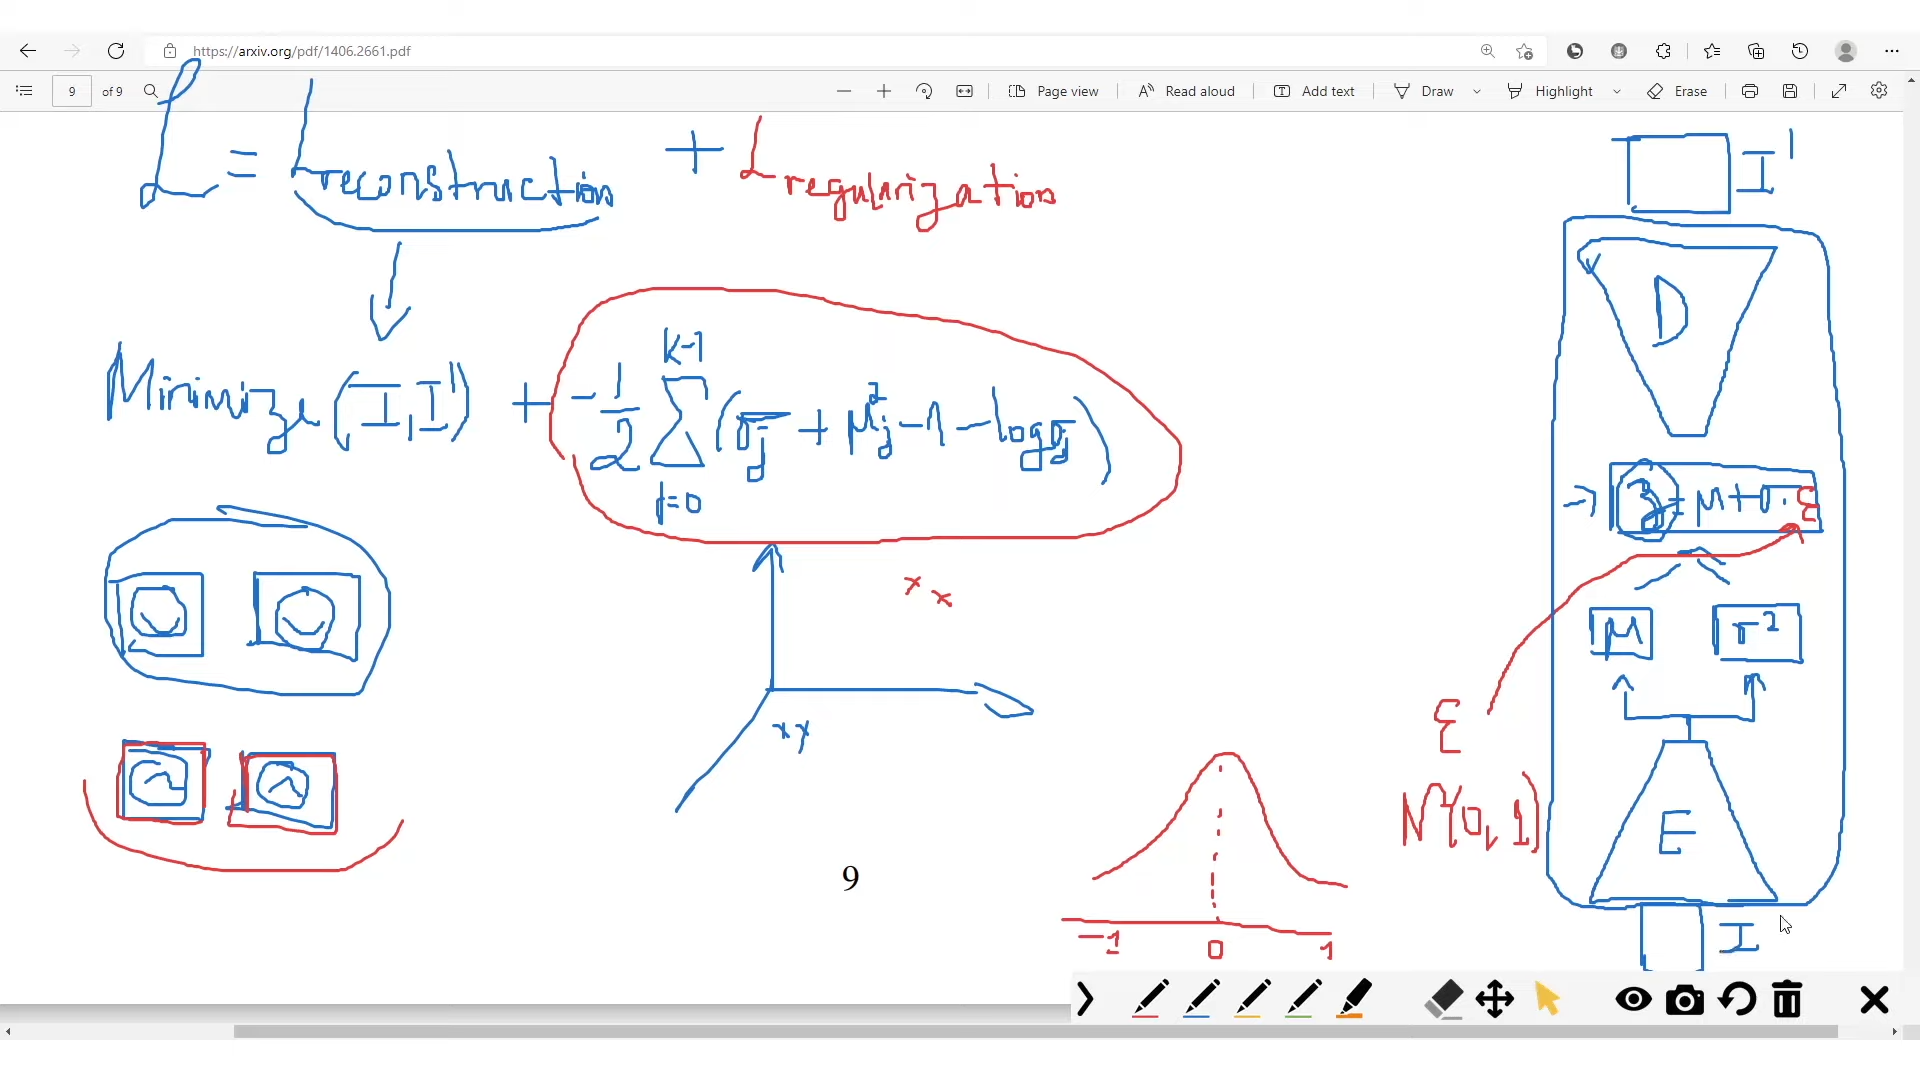

In [ ]:
# for loss we are calculating 2 things , 1) our regularization loss and 2) our reconstruction loss
# also for loss we've to have one single value , hence we see we are doing reduce_sum along the specified axis (1,2 --> refering with (batch_size ,28,28,1) and extracting only (28,28)) and for reg_loss we're extracting (2) from (bathc_size, 2)
# hence we recieved the mean value for both the reg_loss and rec_loss

def custom_loss(y_true , y_pred, mean, log_var):
  rec_loss = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(y_true, y_pred), axis = (1,2)))
  reg_loss = -0.5*(1+ log_var - tf.math.square(mean) - tf.math.exp(log_var))

  return rec_loss + tf.reduce_mean(tf.reduce_sum(reg_loss, axis=1))

## VAE MODEL

In [ ]:
vae_inputs = Input(shape=(28,28,1), name="vae_inputs")

z , _ , _  = encoder_model(vae_inputs)
output = decoder_model(z)

vae_model =  Model(vae_inputs, output, name="vae_model")
vae_model.summary()

Model: "vae_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vae_inputs (InputLayer)     [(None, 28, 28, 1)]       0         
                                                                 
 encoder_model (Functional)  [(None, 2),               69076     
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder_model (Functional)  (None, 28, 28, 1)         65089     
                                                                 
Total params: 134,165
Trainable params: 134,165
Non-trainable params: 0
_________________________________________________________________


In [ ]:
@tf.function
def training_block(y_true):
  with tf.GradientTape() as recorder:
    z, mean, log_var = encoder_model(y_true)
    y_pred = decoder_model(z)
    loss =  custom_loss(y_true, y_pred, mean, log_var)

  partial_derivatives = recorder.gradient(loss, vae_model.trainable_weights)
  optimizer.apply_gradients(zip(partial_derivatives, vae_model.trainable_weights))

  return loss

In [ ]:
def neural_net(Epochs):
  for epoch in range(1, Epochs+1):
    print("Training for {} epoch has been started".format(epoch))

    for step , test_batch in enumerate(train_dataset):
      loss = training_block(test_batch)

    print("here we get loss too {}".format(loss))
  print("Training Complete!!!!!!!!!!!!!")

In [ ]:
neural_net(epochs)

Streaming output truncated to the last 5000 lines.
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.frame

## Overriding train_step method

In [ ]:
class VAE(tf.keras.Model):
  def __init__(self, encoder_model, decoder_model):
    super(VAE, self).__init__()
    self.encoder = encoder_model
    self.decoder = decoder_model
    self.loss_tracker = tf.keras.metrics.Mean(name="loss")
  @property
  def metrics(self):
    return [self.loss_tracker]

  def train_step(self, x_batch):
    with tf.GradientTape() as recorder:
      z, mean, log_var = encoder_model(x_batch)
      y_pred = decoder_model(z)
      y_true = x_batch
      loss = cust om_loss(y_true, y_pred, mean, log_var)

    partial_derivatives = recorder.gradient(loss, self.trainable_weights)
    optimizer.apply_gradients(zip(partial_derivatives, self.trainable_weights))

    self.loss_tracker.update_state(loss)
    return {'loss' : self.loss_tracker.result()}

In [ ]:
model =VAE(encoder_model, decoder_model)
model.compile(optimizer = optimizer)
model.fit(train_dataset, epochs=100, batch_size=128)

Epoch 1/100
547/547 [==============================] - 6s 8ms/step - loss: 147.9530
Epoch 2/100
547/547 [==============================] - 5s 8ms/step - loss: 147.9440
Epoch 3/100
547/547 [==============================] - 5s 8ms/step - loss: 147.8513
Epoch 4/100
547/547 [==============================] - 4s 8ms/step - loss: 147.8085
Epoch 5/100
547/547 [==============================] - 5s 8ms/step - loss: 147.7705
Epoch 6/100
547/547 [==============================] - 4s 8ms/step - loss: 147.7849
Epoch 7/100
547/547 [==============================] - 4s 8ms/step - loss: 147.6990
Epoch 8/100
547/547 [==============================] - 5s 8ms/step - loss: 147.6652
Epoch 9/100
547/547 [==============================] - 4s 8ms/step - loss: 147.7146
Epoch 10/100
547/547 [==============================] - 5s 8ms/step - loss: 147.6199
Epoch 11/100
547/547 [==============================] - 4s 8ms/step - loss: 147.6231
Epoch 12/100
547/547 [==============================] - 4s 8ms/step - loss

# Testing

In [ ]:
scale = 1
n = 16

In [ ]:
# for gradient_descent we try to minize the loss while for gradient_ascend we try to maximize the loss
# GD---> 	θi = 	θ(i-1) - d(loss)/d(θi-1)
# GA---> 	θi = 	θ(i-1) + d(loss)/d(θi-1)

# now for our loss function , what we've on first half is the log(Discriminator) now our Discriminator is such that it would only produce 0 (fake image) or 1 (real image). Now, if we've Discriminator=1 then (log(Discriminator) == log(1)) = 0 hence for lef part we always want it to be 0 for best results
# now for our second half(right part) we have ----> z which is random noise which is being multiplied by Generator which is then multiplied by the Discriminator ultimately giving 0 hence 1-0 gives  1 and log(1) is 0 hence for our whole Discriminator gradient_assend the max value is 0

# The above 2 steps are just for the discriminator

# In Generator




In [ ]:
grid_x = np.linspace(-scale, scale, 16)
grid_y = np.linspace(-scale, scale, 16)

In [ ]:
print(grid_x, grid_y)

[-1.         -0.86666667 -0.73333333 -0.6        -0.46666667 -0.33333333
 -0.2        -0.06666667  0.06666667  0.2         0.33333333  0.46666667
  0.6         0.73333333  0.86666667  1.        ] [-1.         -0.86666667 -0.73333333 -0.6        -0.46666667 -0.33333333
 -0.2        -0.06666667  0.06666667  0.2         0.33333333  0.46666667
  0.6         0.73333333  0.86666667  1.        ]


1/1 [==============================] - 0s 16ms/step


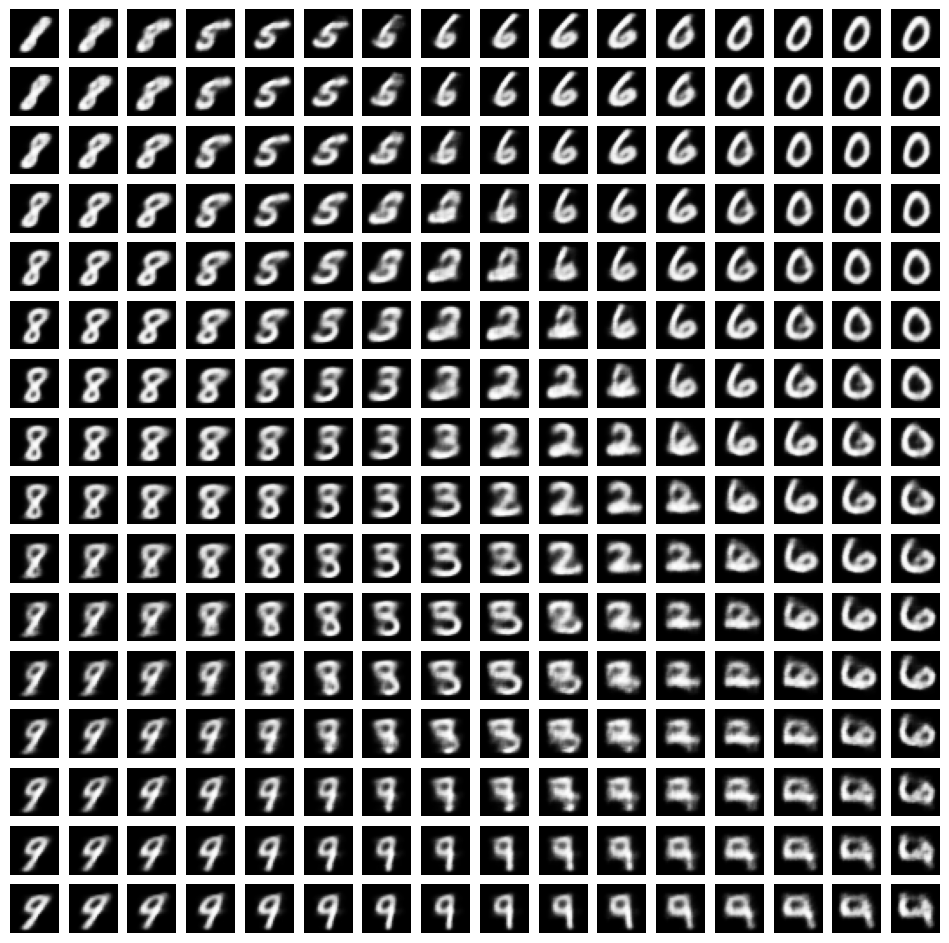

In [ ]:
plt.figure(figsize=(12,12))
k=0
for i in grid_x:
  for j in grid_y:
    ax= plt.subplot(n, n ,k+1)

    input = tf.constant([[i, j]])
    out  = model.decoder.predict(input)[0][...,0]
    plt.imshow(out, cmap="Greys_r")
    plt.axis('off')
    k+=1